# Dataset Preparation & EDA

In [1]:
!pip install datasets pandas matplotlib seaborn


In [2]:
import sys
!{sys.executable} -m pip install scikit-learn


In [3]:
#Load the MovieLens Dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set up clean plot styles
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Paths (modify these as needed)
ratings_path = "MoviesLense/ratings.csv"
movies_path = "MoviesLense/movies.csv"

# Load datasets
ratings = pd.read_csv(ratings_path)
movies = pd.read_csv(movies_path)

# Display basic info
print("Ratings Dataset:")
print(ratings.info())
print("\nMovies Dataset:")
print(movies.info())

# Display first few rows
print("\nSample Ratings Data:")
print(ratings.head())
print("\nSample Movies Data:")
print(movies.head())


Ratings Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000204 entries, 0 to 32000203
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 976.6 MB
None

Movies Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None

Sample Ratings Data:
   userId  movieId  rating  timestamp
0       1       17     4.0  944249077
1       1       25     1.0  944250228
2       1       29     2.0  943230976
3       1       30     5.0  944249077
4       1       32     5.0  943228858

Sample Movies Data:
   movieId                      

In [4]:
# Merge Datasets and Convert Timestamps

# Merge ratings with movie titles
movie_data = pd.merge(ratings, movies, on="movieId")

# Convert timestamp
movie_data['timestamp'] = pd.to_datetime(movie_data['timestamp'], unit='s')

# Preview merged dataset
movie_data.head()


,userId,movieId,rating,timestamp,title,genres
0,1,17,4.0,1999-12-03 19:24:37,Sense and Sensibility (1995),Drama|Romance
1,1,25,1.0,1999-12-03 19:43:48,Leaving Las Vegas (1995),Drama|Romance
2,1,29,2.0,1999-11-22 00:36:16,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
3,1,30,5.0,1999-12-03 19:24:37,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Crime|Drama
4,1,32,5.0,1999-11-22 00:00:58,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller


In [5]:
# Missing Values and Basic Stats
# Check for missing values
print(movie_data.isnull().sum())

# Summary statistics
print(movie_data.describe())

# Number of unique users and movies
num_users = movie_data['userId'].nunique()
num_movies = movie_data['movieId'].nunique()

print(f"Unique Users: {num_users}")
print(f"Unique Movies: {num_movies}")


userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64
             userId       movieId        rating                      timestamp
count  2.997239e+07  2.997239e+07  2.997239e+07                       29972393
mean   1.002952e+05  2.251514e+04  3.557734e+00  2009-12-16 11:00:01.592061952
min    1.000000e+00  1.000000e+00  5.000000e-01            1995-01-09 11:46:44
25%    5.004600e+04  1.207000e+03  3.000000e+00            2002-12-09 19:02:28
50%    1.003430e+05  3.055000e+03  4.000000e+00            2009-06-07 14:36:29
75%    1.504280e+05  2.649800e+04  4.000000e+00            2017-03-08 21:45:56
max    2.009480e+05  1.936090e+05  5.000000e+00            2023-10-13 02:28:18
std    5.794683e+04  3.932365e+04  1.053607e+00                            NaN
Unique Users: 200946
Unique Movies: 9454


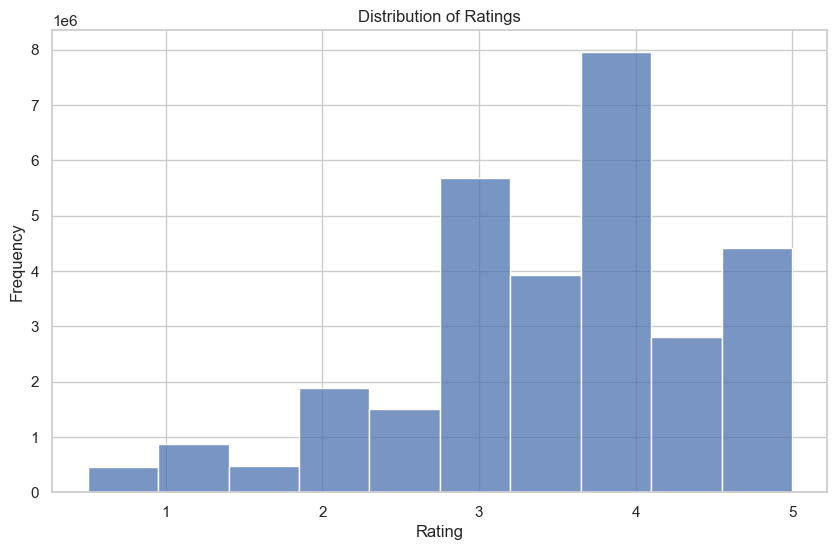

In [6]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Create directory for saving plots
os.makedirs("plots", exist_ok=True)

# Plot Rating Distribution
plt.figure()
sns.histplot(movie_data['rating'], bins=10, kde=False)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.savefig("plots/rating_distribution.png")
plt.show()


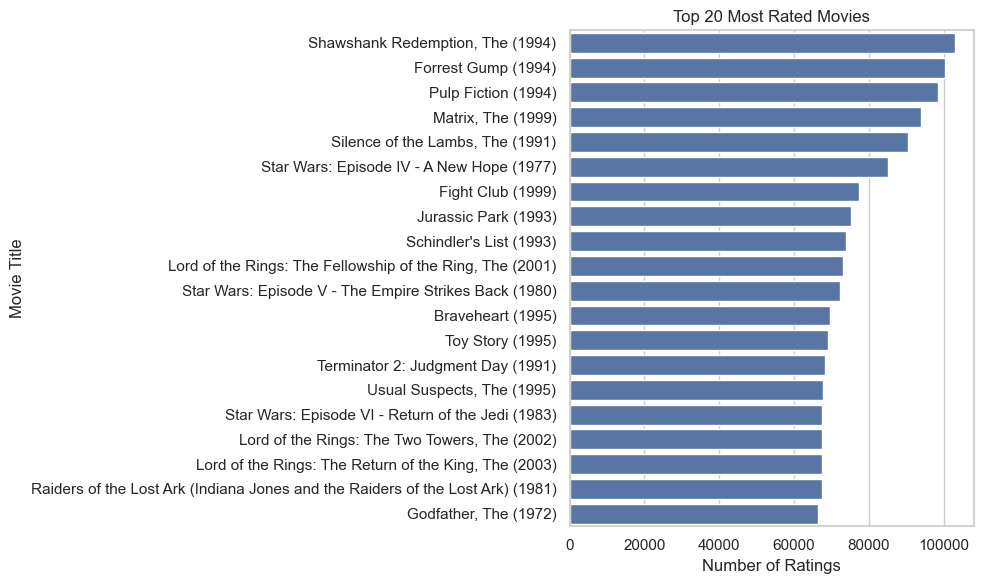

In [7]:
# Plot – Top 20 Most Rated Movies
top_movies = movie_data['title'].value_counts().head(20)

plt.figure()
sns.barplot(y=top_movies.index, x=top_movies.values)
plt.title("Top 20 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")
plt.tight_layout()
plt.savefig("plots/top_20_most_rated_movies.png")
plt.show()


In [8]:
#Extract and Encode Genres

#Each movie can have multiple genres (e.g., "Action|Adventure|Sci-Fi"). We’ll:

# 1.Split genres.
# 2.One-hot encode them for Content-Based Filtering.

#extract genre information
# Split genre strings into lists
movies['genres'] = movies['genres'].apply(lambda x: x.split('|') if isinstance(x, str) else [])

#Create Genre One-Hot Encoding
# Get all unique genres
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
genre_matrix = pd.DataFrame(mlb.fit_transform(movies['genres']),
                            columns=mlb.classes_,
                            index=movies['movieId'])

# Combine with original movie info
movies_with_genres = pd.concat([movies[['movieId', 'title']], genre_matrix], axis=1)

# Preview encoded genre matrix
movies_with_genres.head()

#Merge Genre Data with Ratings
# Merge with ratings
# Merge genre info directly with ratings
merged_data = pd.merge(ratings, movies_with_genres, on="movieId")

# Optional: reorder columns for readability
cols = ['userId', 'movieId', 'title', 'rating'] + list(genre_matrix.columns)
merged_data = merged_data[cols]

# Preview
merged_data.head()



,userId,movieId,title,rating,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,17,Sense and Sensibility (1995),4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,25,Leaving Las Vegas (1995),1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,29,"City of Lost Children, The (Cité des enfants p...",2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,30,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,5.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Build a Content-Based Recommendation System


In [13]:
# Reload fresh movies.csv
movies = pd.read_csv("MoviesLense/movies.csv")

# Print the first few rows
print("Sample rows:")
print(movies.head(3))

# Print one specific genre entry
print("\nFirst genre entry (raw):", movies.loc[0, 'genres'])

# Split genre strings into lists
movies['genres'] = movies['genres'].fillna('').apply(lambda x: x.split('|'))

print("Split genres (first 3 rows):")
print(movies['genres'].head(3))


from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
genre_matrix = pd.DataFrame(
    mlb.fit_transform(movies['genres']),
    columns=mlb.classes_,
    index=movies.index
)

print("Genre matrix shape:", genre_matrix.shape)
print("Genres encoded:", genre_matrix.columns.tolist())


Sample rows:
   movieId                    title  \
0        1         Toy Story (1995)   
1        2           Jumanji (1995)   
2        3  Grumpier Old Men (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  

First genre entry (raw): Adventure|Animation|Children|Comedy|Fantasy
Split genres (first 3 rows):
0    [Adventure, Animation, Children, Comedy, Fantasy]
1                       [Adventure, Children, Fantasy]
2                                    [Comedy, Romance]
Name: genres, dtype: object
Genre matrix shape: (9742, 20)
Genres encoded: ['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [9]:
# Finalize Cosine Similarity Matrix
#Content-Based Similarity Between Movies (Genre-Only)
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity

# STEP 1: Load clean movies.csv (~9742 rows)
movies = pd.read_csv("MoviesLense/movies.csv")
movies['genres'] = movies['genres'].fillna('').astype(str).apply(lambda x: x.split('|'))
movies = movies.drop_duplicates(subset='title').reset_index(drop=True)

# STEP 2: One-hot encode genres
mlb = MultiLabelBinarizer()
genre_matrix = pd.DataFrame(
    mlb.fit_transform(movies['genres']),
    columns=mlb.classes_,
    index=movies['title']
)

# STEP 3: Compute similarity
cosine_sim = cosine_similarity(genre_matrix.values)
cosine_sim_df = pd.DataFrame(
    cosine_sim,
    index=genre_matrix.index,
    columns=genre_matrix.index
)

# STEP 4: Recommender function
def get_similar_movies(movie_title, top_n=5):
    if movie_title not in cosine_sim_df.columns:
        print(f"❌ Movie '{movie_title}' not found.")
        return []
    sim_scores = cosine_sim_df[movie_title].sort_values(ascending=False)
    return sim_scores.iloc[1:top_n+1]

# STEP 5: Test it
print("🎬 Similar to 'Toy Story (1995)':")
print(get_similar_movies("Toy Story (1995)", top_n=8))


🎬 Similar to 'Toy Story (1995)':
title
Adventures of Rocky and Bullwinkle, The (2000)    1.0
Emperor's New Groove, The (2000)                  1.0
Monsters, Inc. (2001)                             1.0
Tale of Despereaux, The (2008)                    1.0
Wild, The (2006)                                  1.0
Moana (2016)                                      1.0
Antz (1998)                                       1.0
Turbo (2013)                                      1.0
Name: Toy Story (1995), dtype: float64


# Collaborative Filtering (Matrix Factorization model (SVD))

In [ ]:
# Recommend movies to a target user based on ratings from similar users.


In [12]:
# Create User-Item Matrix + Similarity
# Collaborative Filtering with Surprise (SVD Model)

# 📦 Step 1: Install scikit-surprise (only run once if not installed)
# pip install scikit-surprise

# Step 1: Show your Jupyter Python path (to make sure we're installing in the correct environment)
import sys
print(sys.executable)


C:\Users\adnan\anaconda3\envs\movielens_env\python.exe


In [15]:
# 📌 Step 2: Imports

from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split
from collections import defaultdict

#  Step 3: Load the ratings data (from MovieLens 25M)
ratings_df = pd.read_csv("MoviesLense/ratings.csv")  #  Update path if needed

# SAMPLE: Use only the first 500,000 rows for faster testing
ratings_df = ratings_df.sample(n=500000, random_state=42).reset_index(drop=True)
print(" Ratings loaded:", ratings_df.shape)

#  Step 4: Prepare data for Surprise
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

#  Step 5: Split into training and test sets
trainset, testset = train_test_split(data, test_size=0.1, random_state=42)

#  Step 6: Build and train SVD model
model = SVD()
model.fit(trainset)

#  Step 7: Predict ratings on test set
predictions = model.test(testset)

#  Step 8: Evaluate RMSE
rmse = accuracy.rmse(predictions)
print(" RMSE:", rmse)

#  Step 9: Function to get Top-N recommendations
def get_top_n(predictions, n=5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Sort and keep top N
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

top_n = get_top_n(predictions, n=5)

#  Step 10: Load movie titles to map movieId → title
movies_df = pd.read_csv("MoviesLense/movies.csv")
movie_lookup = dict(zip(movies_df['movieId'], movies_df['title']))

#  Step 11: Show top 5 recommendations for a user (e.g., userId = 1)
print("\n Top 5 recommendations for user 1:")
for movie_id, pred_rating in top_n[1]:
    movie_title = movie_lookup.get(movie_id, "Unknown Movie")
    print(f"{movie_title} → Predicted Rating: {pred_rating:.2f}")

#as user 1 might be not in sample of 500,000 so we will try toget recommendation for existing user in 500,000
# Pick any existing user from the predictions
sample_user = list(top_n.keys())[0]  # grab the first user with predictions

print(f"\n🎬 Top 5 recommendations for user {sample_user}:")
for movie_id, pred_rating in top_n[sample_user]:
    movie_title = movie_lookup.get(movie_id, "Unknown Movie")
    print(f"{movie_title} → Predicted Rating: {pred_rating:.2f}")

#to see all available users
print("Sample user IDs with recommendations:", list(top_n.keys())[:10])


 Ratings loaded: (500000, 4)
RMSE: 0.9367
 RMSE: 0.9366529705845251

 Top 5 recommendations for user 1:

🎬 Top 5 recommendations for user 11403:
Seven Pounds (2008) → Predicted Rating: 3.60
Sample user IDs with recommendations: [11403, 83894, 108576, 151929, 76606, 16774, 99774, 141322, 174165, 138298]


# Matrix Factorization Model Comparison

In [16]:
import pandas as pd
from surprise import Dataset, Reader, SVD, SVDpp, NMF, accuracy
from surprise.model_selection import train_test_split

# 🔹 Step 1: Load full ratings dataset
ratings_df = pd.read_csv("MoviesLense/ratings.csv")
print("✅ Full dataset shape:", ratings_df.shape)

# 🔹 Step 2: Sample 500,000 rows for faster comparison
ratings_sample = ratings_df.sample(n=500000, random_state=42)
print("✅ Sampled dataset shape:", ratings_sample.shape)

# 🔹 Step 3: Load data into Surprise
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_sample[['userId', 'movieId', 'rating']], reader)

# 🔹 Step 4: Train-test split
trainset, testset = train_test_split(data, test_size=0.1, random_state=42)


✅ Full dataset shape: (32000204, 4)
✅ Sampled dataset shape: (500000, 4)


In [17]:
#  Train and Compare Models (SVD, SVD++, NMF)

from time import time

models = {
    "SVD": SVD(),
    "SVD++": SVDpp(),
    "NMF": NMF()
}

results = {}

for name, model in models.items():
    print(f"\n🔧 Training {name}...")
    start = time()
    model.fit(trainset)
    predictions = model.test(testset)
    rmse = accuracy.rmse(predictions)
    end = time()
    
    results[name] = {
        "rmse": rmse,
        "time": round(end - start, 2)
    }



🔧 Training SVD...
RMSE: 0.9356

🔧 Training SVD++...
RMSE: 0.9323

🔧 Training NMF...
RMSE: 1.0811


In [18]:
# Show RMSE and Training Time Comparison

print("\n📈 Model Comparison (on 500K sample):")
for model_name, metrics in results.items():
    print(f"{model_name}: RMSE = {metrics['rmse']:.4f}, Time = {metrics['time']}s")



📈 Model Comparison (on 500K sample):
SVD: RMSE = 0.9356, Time = 22.33s
SVD++: RMSE = 0.9323, Time = 20.55s
NMF: RMSE = 1.0811, Time = 36.03s


# Model Comparison Visualized

In [20]:
#  Prepare the data for plotting

import matplotlib.pyplot as plt

# Extract model names, RMSE, and time
model_names = list(results.keys())
rmse_values = [results[m]['rmse'] for m in model_names]
time_values = [results[m]['time'] for m in model_names]


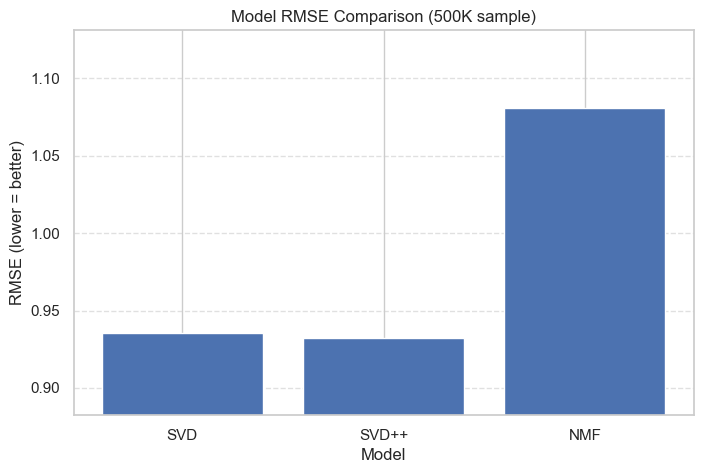

In [21]:
# Plot RMSE Comparison

plt.figure(figsize=(8, 5))
plt.bar(model_names, rmse_values)
plt.title("Model RMSE Comparison (500K sample)")
plt.ylabel("RMSE (lower = better)")
plt.xlabel("Model")
plt.ylim(min(rmse_values) - 0.05, max(rmse_values) + 0.05)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


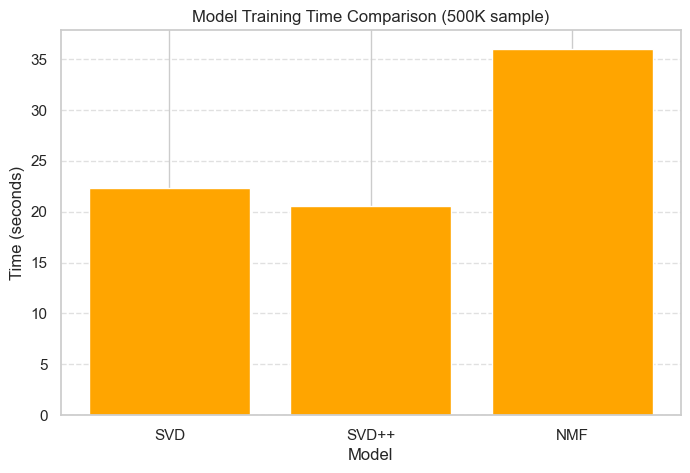

In [22]:
# Plot Training Time Comparison
plt.figure(figsize=(8, 5))
plt.bar(model_names, time_values, color='orange')
plt.title("Model Training Time Comparison (500K sample)")
plt.ylabel("Time (seconds)")
plt.xlabel("Model")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


# Evaluate Precision and Recall

In [26]:
# Run on Predictions from Best Model

##Let's assume svd++_model is your best trained model 

from surprise import SVDpp, accuracy
from surprise.model_selection import train_test_split
from surprise import Dataset, Reader
from collections import defaultdict

# Step 1: Load and sample the data
ratings_df = pd.read_csv("MoviesLense/ratings.csv")
ratings_df = ratings_df.sample(n=500000, random_state=42).reset_index(drop=True)

# Step 2: Prepare data for Surprise
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.1, random_state=42)

# Step 3: Train SVD++ model
svdpp_model = SVDpp()
svdpp_model.fit(trainset)

# Step 4: Make predictions
predictions = svdpp_model.test(testset)

# Step 5: Define evaluation function
def precision_recall_at_k(predictions, k=5, threshold=3.5):
    """Return precision and recall at k metrics."""
    user_est_true = defaultdict(list)

    # Organize predictions by user
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()

    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Top-K predictions
        top_k = user_ratings[:k]

        # Compute relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in top_k)
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in top_k)

        # Precision and Recall
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

# Step 6: Evaluate
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.5)
avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
avg_recall = sum(rec for rec in recalls.values()) / len(recalls)

print(f"\n🎯 Precision@5: {avg_precision:.4f}")
print(f"🎯 Recall@5:    {avg_recall:.4f}")



🎯 Precision@5: 0.5150
🎯 Recall@5:    0.5092


# Visualizing User-Movie Interactions and Trends

In [27]:
# Ratings Distribution and Summary Stats
#  Ratings Distribution Plot

#Load Data (if not already in memory)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load ratings data (if not already loaded)
ratings_df = pd.read_csv("MoviesLense/ratings.csv")

# Optional: inspect basic info
print(ratings_df.head())
print(ratings_df['rating'].describe())


   userId  movieId  rating  timestamp
0       1       17     4.0  944249077
1       1       25     1.0  944250228
2       1       29     2.0  943230976
3       1       30     5.0  944249077
4       1       32     5.0  943228858
count    3.200020e+07
mean     3.540396e+00
std      1.058986e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


C:\Users\adnan\AppData\Local\Temp\ipykernel_41136\1772855090.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings_df, palette='Blues')


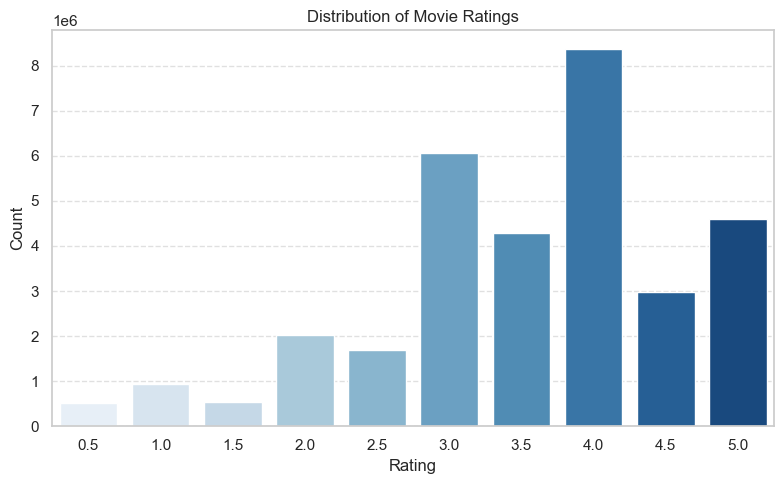

In [29]:
# Plot Histogram of Ratings

plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=ratings_df, palette='Blues')
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [29]:
# Top 10 Most Rated Movies

##Merge Ratings with Movie Titles

# Load movies.csv
movies_df = pd.read_csv("MoviesLense/movies.csv")

# Merge with ratings to get titles
merged_df = pd.merge(ratings_df, movies_df, on='movieId')


In [30]:
# Group and Count Ratings

# Count number of ratings per movie
rating_counts = merged_df.groupby('title')['rating'].count().sort_values(ascending=False)

# Get top 10
top_10 = rating_counts.head(10)


C:\Users\adnan\AppData\Local\Temp\ipykernel_3884\2013640218.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10.values, y=top_10.index, palette='mako')


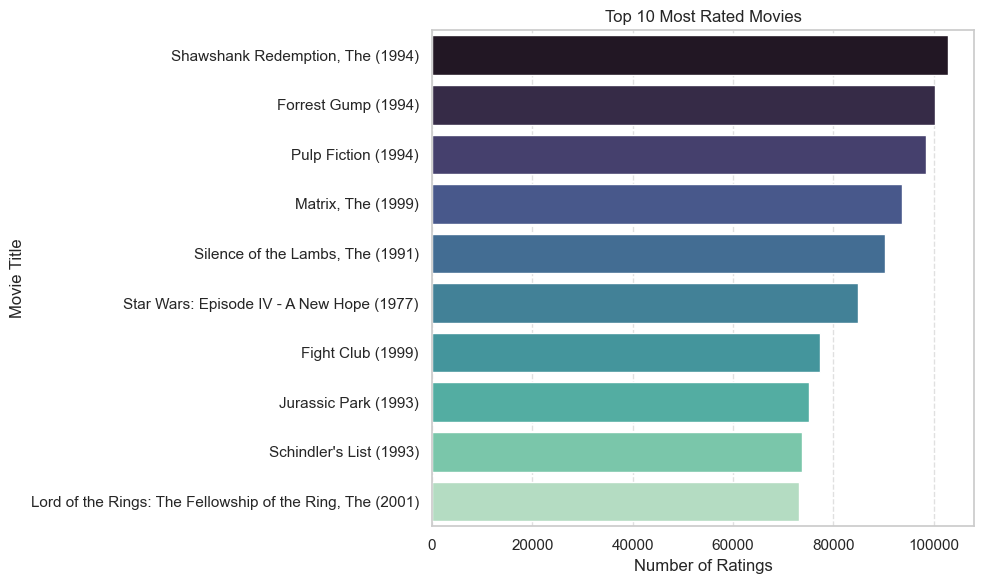

In [31]:
# Plot

plt.figure(figsize=(10, 6))
sns.barplot(x=top_10.values, y=top_10.index, palette='mako')
plt.title("Top 10 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# User-Movie Matrix Sparsity Visualization

In [ ]:
#W e'll use a small subset for visualization (~100 users × 100 movies)
# Otherwise, the matrix is too large to render in a notebook.

✅ Pivot shape: (500, 500)


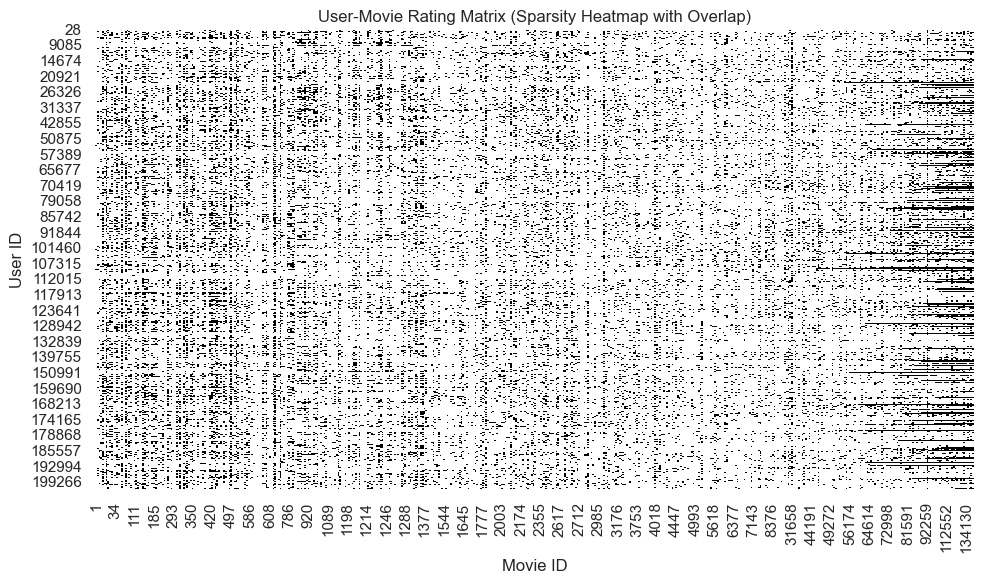

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load ratings (if not already loaded)
ratings_df = pd.read_csv("MoviesLense/ratings.csv")

# Step 2: Get top 10 most rated movies
top_movies = ratings_df['movieId'].value_counts().head(500).index
subset_movies = ratings_df[ratings_df['movieId'].isin(top_movies)]

# Step 3: Get top 10 most active users (who rated those top movies)
top_users = subset_movies['userId'].value_counts().head(500).index
subset_users_movies = subset_movies[subset_movies['userId'].isin(top_users)]

# Step 4: Create pivot table (User ID vs Movie ID)
pivot = subset_users_movies.pivot(index='userId', columns='movieId', values='rating')

# ✅ Optional: Print shape to confirm
print("✅ Pivot shape:", pivot.shape)

# Step 5: Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot.isnull(), cbar=False, cmap='gray_r')
plt.title("User-Movie Rating Matrix (Sparsity Heatmap with Overlap)")
plt.xlabel("Movie ID")
plt.ylabel("User ID")
plt.tight_layout()
plt.show()


# Optimization

In [ ]:
# Optimize SVD++ Using GridSearchCV
# Surprise has a built-in GridSearchCV just like Scikit-Learn!

In [33]:
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

# Define parameter grid to search for SVD++
param_grid = {
    'n_factors': [50, 100],         # Number of latent factors
    'lr_all': [0.002, 0.005],       # Learning rate
    'reg_all': [0.02, 0.1]          # Regularization strength
}

# Run GridSearchCV on SVD++
gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1, joblib_verbose=2)
gs.fit(data)  # 'data' should be prepared with Reader + Dataset.load_from_df

# Print best score and params
print(" Best RMSE (SVD++):", gs.best_score['rmse'])
print(" Best Parameters (SVD++):", gs.best_params['rmse'])

# Retrieve best model
best_svdpp_model = gs.best_estimator['rmse']


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  24 | elapsed:   59.9s remaining:  3.0min
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:  2.0min remaining:   30.8s


 Best RMSE (SVD++): 0.9322601852490728
 Best Parameters (SVD++): {'n_factors': 50, 'lr_all': 0.005, 'reg_all': 0.1}


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.1min finished


In [34]:
# Retrain Final Model with Best Params

from surprise import SVDpp

# Replace with your GridSearchCV results
best_svdpp = SVDpp(n_factors=50, lr_all=0.005, reg_all=0.1)

# Build full trainset from data (make sure `data` is already defined)
trainset = data.build_full_trainset()

# Train the final model
best_svdpp.fit(trainset)

print("✅ Final SVD++ model trained on full dataset.")



✅ Final SVD++ model trained on full dataset.


In [37]:
#save the trained model
import joblib
joblib.dump(best_svdpp, "webapp/svdpp_best_model.pkl")


['webapp/svdpp_best_model.pkl']

In [ ]:
import sys
!"{sys.executable}" -m streamlit run webapp/app.py


In [ ]:
import os
os.remove("webapp/svd_model.pkl")
